In [40]:
import itertools
import json
import os
import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline 

In [41]:
tasks = [
    146805, 146806, 146807, 146808, 146809, 146810, 146811
]
tasks.sort()

In [58]:
def read_one_task(dir, task, strategy, metalearning):
    trajectories = []
    for i in range(1, 16):
        filename = os.path.join(
            dir, 
            '%d_%s_%d_%d' % (task, strategy, metalearning, i),
            'smac3-output', 
            'run_%d' % i,
            #'trajectory.json',
            'validation_trajectory.json',
        )
        trajectory = {}
        if not os.path.exists(filename):
            print('Could not find %s!' % filename)
            continue
        with open(filename) as fh:
            jason = json.load(fh)
            for j in jason:
                try:
                    timestep = j[5]
                    # Training loss
                    # trajectory[timestep] = min(1, j[0])
                    # Test loss
                    trajectory[timestep] = j[7].get('balanced_accuracy', 1.0)
                except Exception as e:
                    print(filename, j, flush=True)
                    raise e
        if np.max(list(trajectory.keys())) < 86400*2:
            trajectory[86400*2] = np.NaN
        trajectory = pd.Series(trajectory)
        trajectories.append(trajectory)
    if len(trajectories) == 0:
        return []
        
    trajectories = pd.DataFrame(trajectories)
    column_0 = trajectories.columns[0]
    trajectories.fillna(value={column_0: 1.0}, inplace=True, axis=0)
    trajectories.fillna(method='ffill', inplace=True, axis=1)
    return trajectories

In [59]:
def make_plotable(trajectories):
    median = trajectories.median()
    percentile_90 = trajectories.quantile(0.9)
    percentile_10 = trajectories.quantile(0.1)
    X = np.array(list(median.index))
    y = median.values
    lower = percentile_10.values
    upper = percentile_90.values
    return X, y, lower, upper

In [60]:
def plot_losses(title, values):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    linestyles = itertools.cycle(['--', ':', '-.'])
    markers = itertools.cycle(['x', 'o', 'd', '^', 's', '*'])
    colors = itertools.cycle(['black', 'green', 'red', 'purple', 'saddlebrown'])
    for key, (X, y, lower, upper) in values.items():
        ax.fill_between(X, lower, upper, alpha=0.3, facecolor=next(colors))
    linestyles = itertools.cycle(['--', ':', '-.'])
    markers = itertools.cycle(['x', 'o', 'd', '^', 's', '*'])
    colors = itertools.cycle(['black', 'green', 'red', 'purple', 'saddlebrown'])
    for key, (X, y, lower, upper) in values.items():  
        ax.plot(X, y, label=key, linestyle=next(linestyles), marker=next(markers), markersize=8, color=next(colors))
    ax.set_xscale("log", nonposx='clip')
    ax.set_xlim((1, 86400*2))
    ax.set_yscale("log", nonposy='clip')
    ax.legend(loc='best')
    ax.set_title(title)
    ax.set_ylabel('loss')
    ax.set_xlabel('time')

146805
{'ROAR': (0.12396382563750663, 0.0089300989700127065, 0.11881831582005886, 1.0),
 'SMAC': (0.12125902545358813,
          0.0098625516184674134,
          0.11813407954318333,
          0.13076259849805472),
 'SMACK': (0.12227612972301427,
           0.011356340939991272,
           0.11751131798472336,
           0.13081161758313964)}
Could not find /home/feurerm/mhome/projects/tasks/2017_11_autosklearn_swith_rs_and_local_search/configuration/146806_ROAR_0_2/smac3-output/run_2/validation_trajectory.json!
Could not find /home/feurerm/mhome/projects/tasks/2017_11_autosklearn_swith_rs_and_local_search/configuration/146806_ROAR_0_4/smac3-output/run_4/validation_trajectory.json!
Could not find /home/feurerm/mhome/projects/tasks/2017_11_autosklearn_swith_rs_and_local_search/configuration/146806_ROAR_0_5/smac3-output/run_5/validation_trajectory.json!
Could not find /home/feurerm/mhome/projects/tasks/2017_11_autosklearn_swith_rs_and_local_search/configuration/146806_ROAR_0_7/smac3-outp

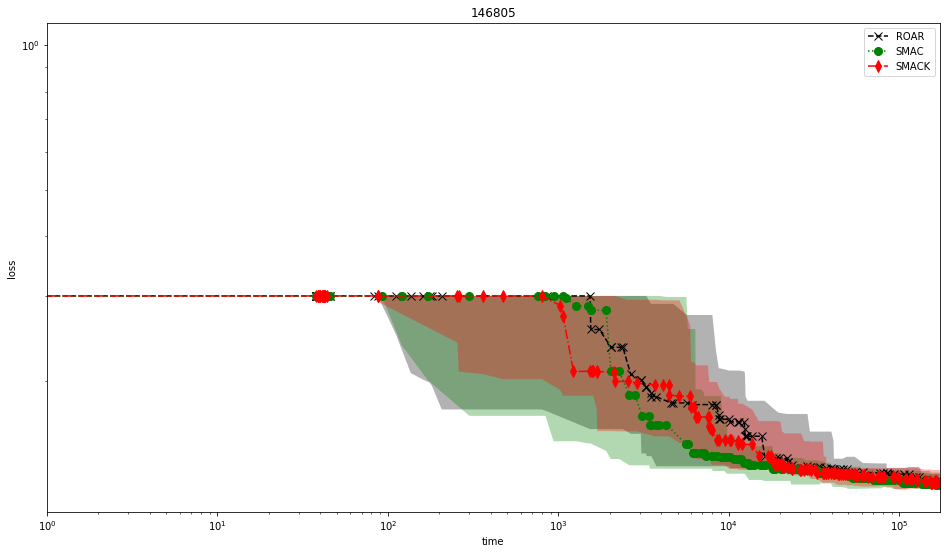

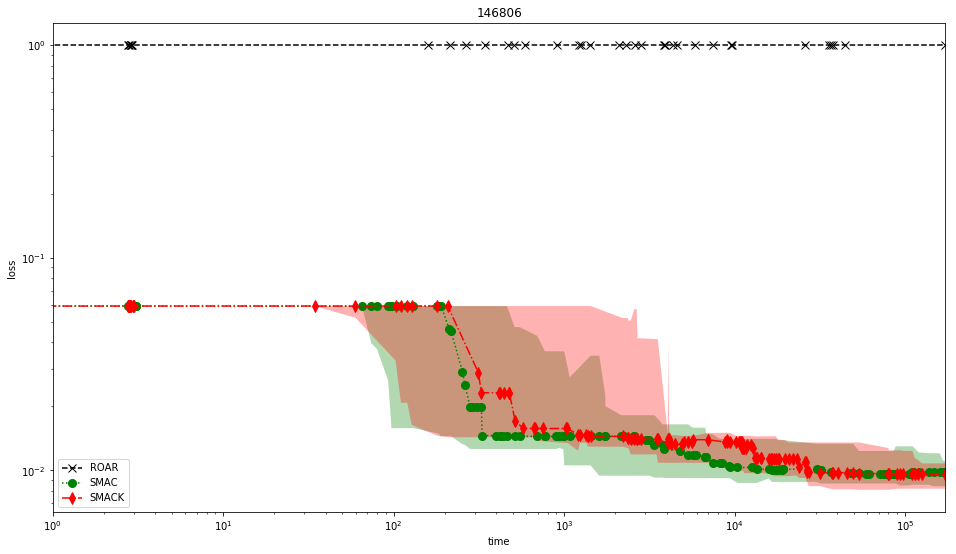

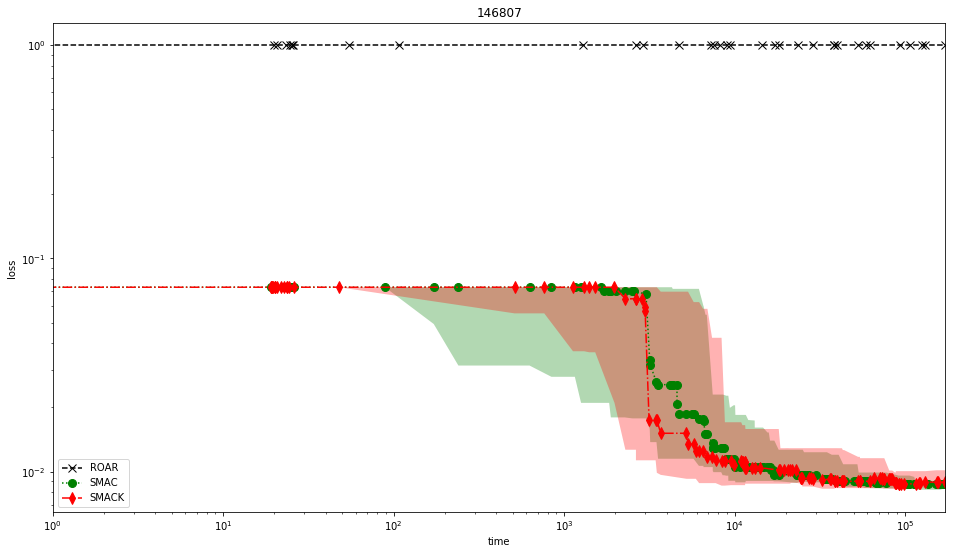

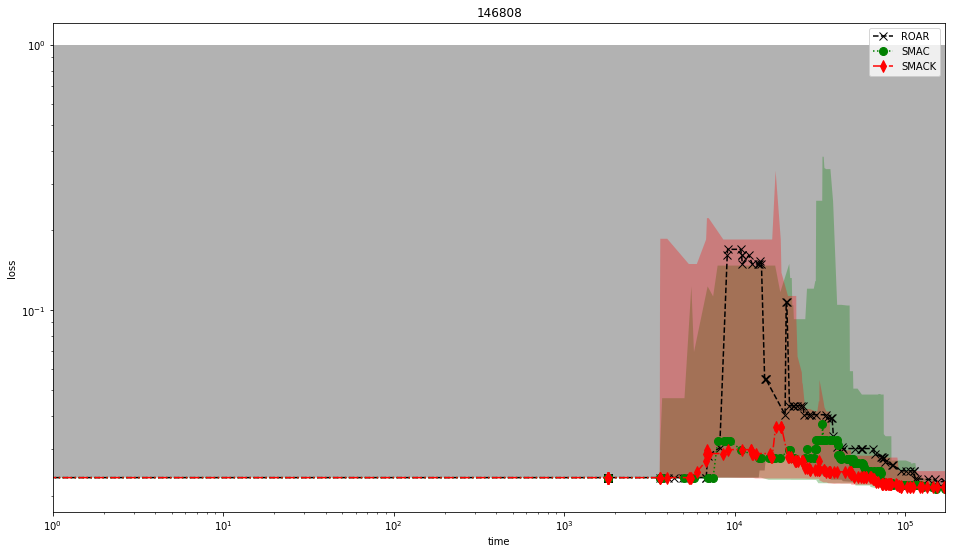

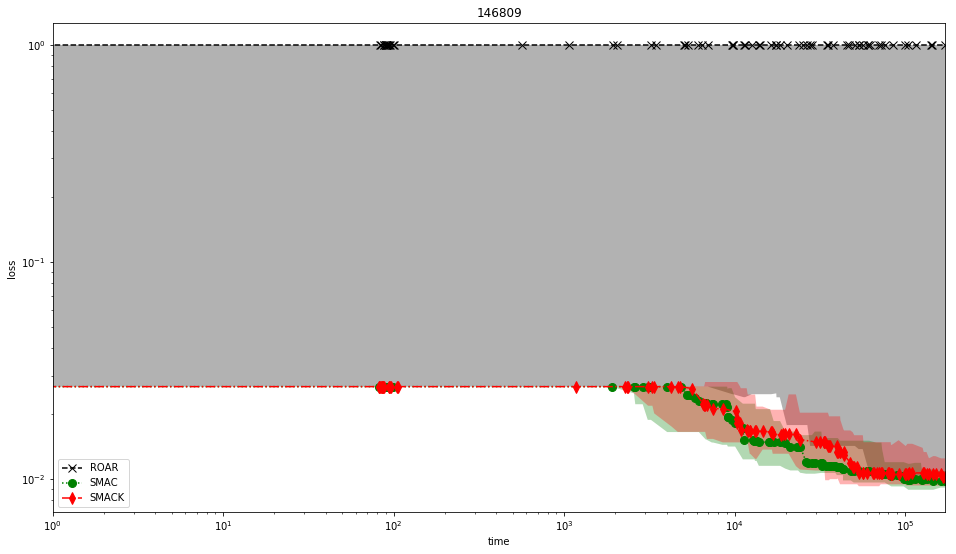

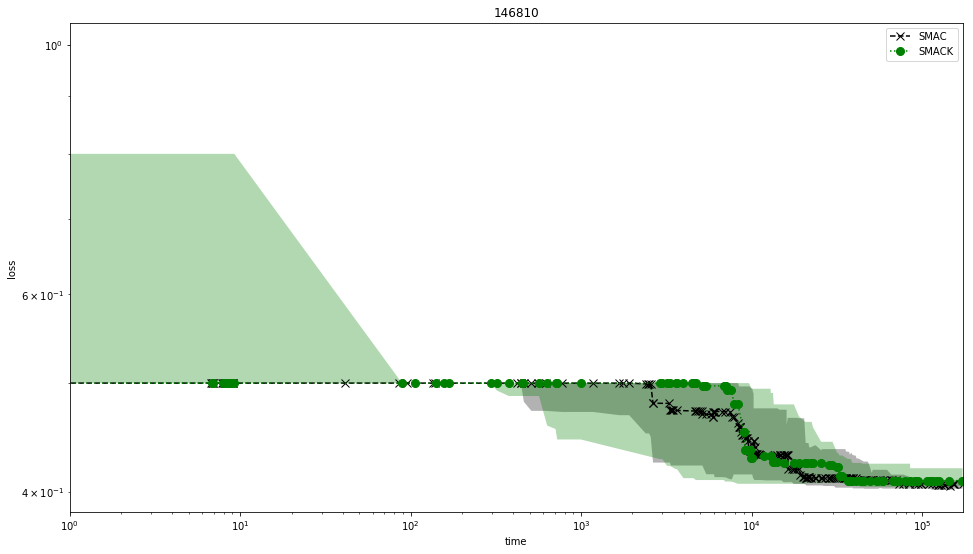

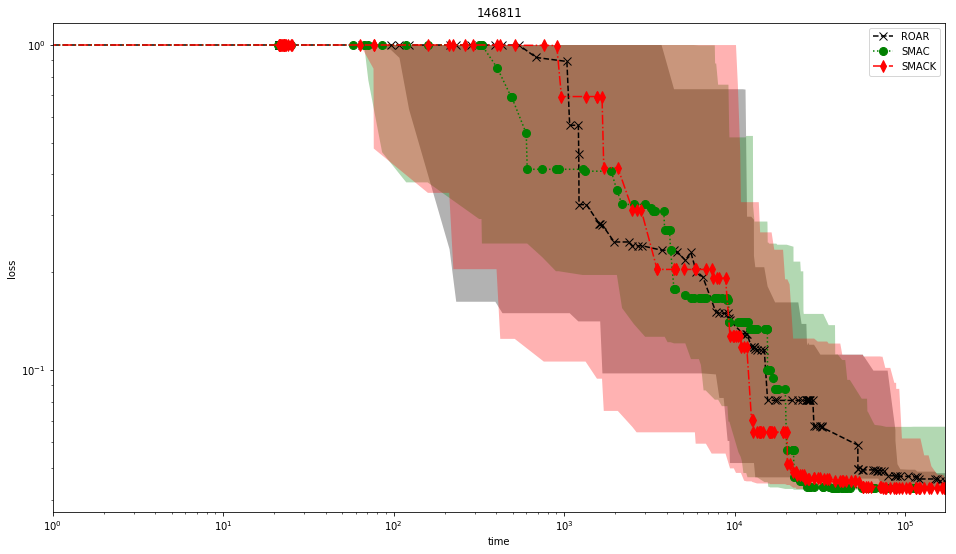

In [63]:
dir = '/home/feurerm/mhome/projects/tasks/2017_11_autosklearn_swith_rs_and_local_search/configuration'
for task in tasks:
    plot_values = {}
    minima = {}
    
    for strategy in ['ROAR', 'SMAC', 'SMACK']:
        trajectories = read_one_task(dir, task, strategy, 0)
        if len(trajectories) > 0:
            plot_values[strategy] = make_plotable(trajectories)
            minima[strategy] = (
                np.median(trajectories.iloc[:, -1]), 
                np.percentile(trajectories.iloc[:, -1], 90) - np.percentile(trajectories.iloc[:, -1], 10),
                np.min(trajectories.iloc[:, -1]),
                np.max(trajectories.iloc[:, -1]),
            )
        
    print(task)
    pprint.pprint(minima)
        
    plot_losses(task, plot_values)

In [207]:
# Plot distribution of target algorithm runs for one run over time
def read_one_run(dir, task, strategy, metalearning, seed):
    filename = os.path.join(
        dir, 
        '%d_%s_%d_%d' % (task, strategy, metalearning, seed),
        'smac3-output', 
        'run_%d' % seed,
        'runhistory.json',
    )
    trajectory = []
    with open(filename) as fh:
        jason = json.load(fh)
        jason = jason['data']
        for j in jason:
            try:
                timestep = j[1][1]
                # Training loss
                trajectory.append((timestep, min(1, j[1][0])))
            except Exception as e:
                print(filename, j, flush=True)
                raise e
    trajectory = pd.DataFrame(trajectory)
        
    #column_0 = trajectories.columns[0]
    #trajectories.fillna(value={column_0: 1.0}, inplace=True, axis=0)
    #trajectories.fillna(method='ffill', inplace=True, axis=1)
    return trajectory

traj = read_one_run(dir, 146809, 'ROAR', 0, 1)
traj

,0,1
0,83.759729,0.044669
1,83.908747,0.043438
2,1800.100408,1.000000
3,97.564242,0.041387
4,228.178345,0.030637
5,231.176510,0.037107
6,236.607464,0.029012
7,218.753730,0.023705
8,1.556398,0.220513
9,225.639353,0.030788


In [208]:
traj_new = traj.copy()
traj_new_by_time = traj_new.copy()
traj_new_by_time[0] = traj_new[0].cumsum()

In [209]:
traj_new.describe()

,0,1
count,11617.000000,11617.000000
mean,13.732342,0.963278
std,84.476069,0.163389
min,0.064887,0.011109
25%,0.120312,1.000000
50%,0.167125,1.000000
75%,1.043323,1.000000
max,1800.117175,1.000000


In [210]:
traj_new_by_time.describe()

,0,1
count,11617.000000,11617.000000
mean,149769.198248,0.963278
std,22307.511647,0.163389
min,83.759729,0.011109
25%,153144.791481,1.000000
50%,154426.344221,1.000000
75%,156339.156258,1.000000
max,159528.611730,1.000000


In [211]:
stepsize = 10
larger_than_one = []
smaller_than_one = []
for i in range(int(traj_new.shape[0] / stepsize)):
    if traj_new.iloc[i*stepsize:i*stepsize+stepsize, 0].mean() > 1:
        larger_than_one.append(i * stepsize)
    else:
        smaller_than_one.append(i * stepsize)
print(larger_than_one)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 2850, 3980, 4580, 4590, 4610, 4680, 4740, 4860, 4950, 4970, 5070, 5150, 5220, 5270, 5290, 5310, 5340, 5370, 5420, 5500, 5520, 5560, 5600, 5630, 5640, 5790, 5860, 5880, 5890, 5920, 6050, 6310, 6520, 6690, 6750, 6900, 6940, 7010, 7020, 7030, 7040, 7110, 7310, 7390, 7420, 7450, 7530, 7570, 7630, 7680, 7740, 7750, 7820, 7860, 7930, 8120, 8220, 8230, 8250, 8320, 8360, 8390, 8400, 8660, 8710, 8810, 8920, 8930, 8970, 9040, 9060, 9100, 9150, 9190, 9220, 9270, 9280, 9290, 9300, 9410, 9460, 9510, 9550, 9570, 9620, 9700, 9740, 9760, 9770, 9800, 9850, 9910, 9940, 9960, 9970, 9990,

In [214]:
stepsize = 100
has_no_result = []
for i in range(int(traj_new.shape[0] / stepsize)):
    if traj_new.iloc[i*stepsize:i*stepsize+stepsize, 1].mean() >= 1:
        has_no_result.append(i * stepsize)
print(has_no_result)

[900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500]


In [163]:
# 3: 5:43 @ run 495
# 13: 13:44 @ run 533
# 14: 1:55 @ run 484
# 15: 5:17 @ run 461